In [1]:
import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.poutine.messenger import Messenger
import pyro.infer.autoguide as ag

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class SuffixMessenger(Messenger):
    
    def __init__(self, param_suffix):
        super().__init__()
        self.param_suffix = param_suffix
        
    def _pyro_param(self, msg):
        msg["name"] = "_".join((msg["name"], self.param_suffix))
        if msg["args"]:
            msg["args"] = (msg["name"],) +  msg["args"][1:]
        else:
            msg["kwargs"]["name"] = msg["name"]

In [3]:
def param_suffix(fn=None, suffix=""):
    msngr = SuffixMessenger(suffix)
    return msngr(fn) if fn is not None else msngr

In [4]:
def guide():
    loc = pyro.param("loc", torch.tensor(0.))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("x", dist.Normal(loc, scale))

In [5]:
pyro.clear_param_store()
guide()

tensor(-0.6181, grad_fn=<AddBackward0>)

In [6]:
list(pyro.get_param_store().items())

[('loc', tensor(0., requires_grad=True)),
 ('scale', tensor(1., grad_fn=<AddBackward0>))]

In [7]:
pyro.clear_param_store()
param_suffix(guide, "task0")()

tensor(-0.3511, grad_fn=<AddBackward0>)

In [8]:
list(pyro.get_param_store().items())

[('loc_task0', tensor(0., requires_grad=True)),
 ('scale_task0', tensor(1., grad_fn=<AddBackward0>))]

In [9]:
class DetachMessenger(Messenger):
        
    def _pyro_post_param(self, msg):
        msg["value"].detach_()

In [10]:
def detach_params(fn=None):
    msngr = DetachMessenger()
    return msngr(fn) if fn is not None else msngr

In [11]:
poutine.trace(detach_params(guide)).get_trace().nodes

OrderedDict([('_INPUT',
              {'name': '_INPUT', 'type': 'args', 'args': (), 'kwargs': {}}),
             ('loc',
              {'type': 'param',
               'name': 'loc',
               'fn': <bound method ParamStoreDict.get_param of <pyro.params.param_store.ParamStoreDict object at 0x7fba95678a60>>,
               'is_observed': False,
               'args': ('loc', tensor(0.)),
               'kwargs': {},
               'value': tensor(0.),
               'scale': 1.0,
               'mask': None,
               'cond_indep_stack': (),
               'done': True,
               'stop': False,
               'continuation': None,
               'infer': {}}),
             ('scale',
              {'type': 'param',
               'name': 'scale',
               'fn': <bound method ParamStoreDict.get_param of <pyro.params.param_store.ParamStoreDict object at 0x7fba95678a60>>,
               'is_observed': False,
               'args': ('scale', tensor(1.)),
               

In [12]:
class ReplaceFnMessenger(Messenger):
    
    def __init__(self, trace=None):
        super().__init__()
        self.trace = trace
        
    def _pyro_sample(self, msg):
        name = msg["name"]
        if self.trace is not None and name in self.trace.nodes:
            guide_msg = self.trace.nodes[name]
            msg["fn"] = guide_msg["fn"]
        return

In [13]:
def replace_fn(fn=None, trace=None):
    msngr = ReplaceFnMessenger(trace)
    return msngr(fn) if fn is not None else msngr

In [14]:
def model(x):
    loc = pyro.sample("loc", dist.Normal(0., 1.))
    with pyro.plate("data"):
        return pyro.sample("x", dist.Normal(loc, 0.1), obs=x)

In [15]:
guide1 = param_suffix(ag.AutoDiagonalNormal(model), "1")
guide2 = param_suffix(ag.AutoDiagonalNormal(model), "2")

In [16]:
x_batched = torch.randn(20) + 2

In [17]:
x1, x2 = x_batched.chunk(2)

In [18]:
pyro.clear_param_store()

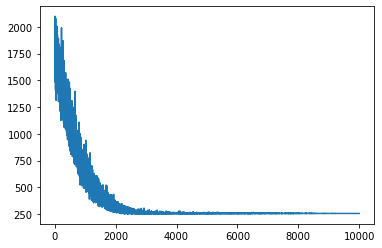

In [19]:
optim = pyro.optim.Adam({"lr": 1e-3})
svi1 = pyro.infer.SVI(model, guide1, optim=optim, loss=pyro.infer.Trace_ELBO())
elbos = [svi1.step(x1) for _ in range(10000)]
plt.plot(elbos)

In [20]:
del pyro.get_param_store()._params["AutoDiagonalNormal.scale"]

In [21]:
list(pyro.get_param_store().items())

[('AutoDiagonalNormal.loc_1',
  Parameter containing:
  tensor([1.8745], requires_grad=True)),
 ('AutoDiagonalNormal.scale_1', tensor([0.0340], grad_fn=<AddBackward0>))]

In [22]:
x1.sum() / 11, 11 ** -0.5

(tensor(1.7122), 0.30151134457776363)

In [23]:
optim = pyro.optim.Adam({"lr": 1e-4})
svi1 = pyro.infer.SVI(replace_fn(model, poutine.trace(detach_params(guide1)).get_trace(x1)), guide2,
                      optim=optim, loss=pyro.infer.Trace_ELBO())
elbos = [svi1.step(x2) for _ in range(10000)]
elbos

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf

In [24]:
list(pyro.get_param_store().items())

[('AutoDiagonalNormal.loc_1',
  Parameter containing:
  tensor([1.8745])),
 ('AutoDiagonalNormal.scale_1', tensor([0.0340], grad_fn=<AddBackward0>)),
 ('AutoDiagonalNormal.scale', tensor([0.0950], grad_fn=<AddBackward0>)),
 ('AutoDiagonalNormal.loc_2',
  Parameter containing:
  tensor([0.8779], requires_grad=True)),
 ('AutoDiagonalNormal.scale_2', tensor([0.0950], grad_fn=<AddBackward0>))]

In [25]:
x1.mean(), x2.mean(), torch.cat((x1, x2)).mean()

(tensor(1.8834), tensor(2.0963), tensor(1.9899))